# Caricamento dataset

In [33]:
import torchaudio

train = torchaudio.datasets.LIBRISPEECH(root="./", url="train-clean-100", download=True)
val = torchaudio.datasets.LIBRISPEECH(root="./", url="dev-clean", download=True)
test = torchaudio.datasets.LIBRISPEECH(root="./", url="test-clean", download=True)

In [34]:
import os

def get_speaker_labels(root_dir):
    speaker_files = []
    labels = []
    count_speakers = 0

    for speaker_id in os.listdir(root_dir):  # Each folder is a speaker
        speaker_path = os.path.join(root_dir, speaker_id)
        count_speakers += 1
        if os.path.isdir(speaker_path):
            for chapter in os.listdir(speaker_path):
                chapter_path = os.path.join(speaker_path, chapter)

                if os.path.isdir(chapter_path):
                    for file in os.listdir(chapter_path):
                        if file.endswith(".flac"):  # LibriSpeech uses FLAC format
                            file_path = os.path.join(chapter_path, file)
                            speaker_files.append(file_path)
                            labels.append(speaker_id)  # Speaker label
    print(f"Number of speakers: {count_speakers}")
    return speaker_files, labels

In [35]:
train_root = "./LibriSpeech/train-clean-100"
val_root = "./LibriSpeech/dev-clean"
test_root = "./LibriSpeech/test-clean"

train_audio_files, train_speaker_labels = get_speaker_labels(train_root)
val_audio_files, val_speaker_labels = get_speaker_labels(val_root)
test_audio_files, test_speaker_labels = get_speaker_labels(test_root)

print(f"Number of training samples: {len(train_audio_files)}")
print(f"Number of validation samples: {len(val_audio_files)}")
print(f"Number of testing samples: {len(test_audio_files)}")

Number of speakers: 251
Number of speakers: 40
Number of speakers: 40
Number of training samples: 28539
Number of validation samples: 2703
Number of testing samples: 2620


In [36]:
import os
from collections import defaultdict

def parse_speaker_metadata(metadata_path):
    """Parsa il file SPEAKERS.TXT e ritorna un dizionario speaker_id -> gender."""
    speaker_gender = {}
    with open(metadata_path, 'r') as f:
        for line in f:
            if line.startswith(';') or not line.strip():
                continue
            parts = line.strip().split('|')
            if len(parts) >= 2:
                speaker_id = parts[0].strip()
                gender = parts[1].strip().lower()
                speaker_gender[speaker_id] = gender
    return speaker_gender

def create_speakers_dict(librispeech_root):
    """
    Scansiona tutte le subset di LibriSpeech e ritorna un unico dizionario speaker_id -> {sex, audio_paths}
    """
    metadata_file = os.path.join(librispeech_root, "SPEAKERS.TXT")
    speaker_gender = parse_speaker_metadata(metadata_file)
    print(len(speaker_gender))

    speakers_dict = defaultdict(lambda: {'sex': None, 'audio_paths': []})

    # Cartelle subset da analizzare
    subsets = ['train-clean-100', 'dev-clean', 'test-clean']

    for subset in subsets:
        subset_path = os.path.join(librispeech_root, subset)
        print(subset_path)
        if not os.path.exists(subset_path):
            continue

        for speaker_id in os.listdir(subset_path):
            speaker_path = os.path.join(subset_path, speaker_id)
            if not os.path.isdir(speaker_path):
                continue

            for chapter_id in os.listdir(speaker_path):
                chapter_path = os.path.join(speaker_path, chapter_id)
                if not os.path.isdir(chapter_path):
                    continue

                for file in os.listdir(chapter_path):
                    if file.endswith(".flac"):
                        file_path = os.path.join(chapter_path, file)
                        speakers_dict[speaker_id]['audio_paths'].append(file_path)

            if speakers_dict[speaker_id]['sex'] is None:
                speakers_dict[speaker_id]['sex'] = speaker_gender.get(speaker_id, "unknown")

    return dict(speakers_dict)


In [37]:
lib_path = "./LibriSpeech"  # modifica con il path corretto
speakers = create_speakers_dict(lib_path)
print(f"Numero speaker trovati: {len(speakers)}")

2484
./LibriSpeech/train-clean-100
./LibriSpeech/dev-clean
./LibriSpeech/test-clean
Numero speaker trovati: 331


In [38]:
# Top 10 male speakers by number of audio_paths
top_male_speakers = sorted(
    [(k, v) for k, v in speakers.items() if v['sex'] == 'm'],
    key=lambda x: len(x[1]['audio_paths']),
    reverse=True
)[:10]

# Top 10 female speakers by number of audio_paths
top_female_speakers = sorted(
    [(k, v) for k, v in speakers.items() if v['sex'] == 'f'],
    key=lambda x: len(x[1]['audio_paths']),
    reverse=True
)[:10]


In [39]:
for speaker_id, speaker_info in top_male_speakers:
    print(f"Speaker ID: {speaker_id}")
    print(f"Gender: {speaker_info['sex']}")
    print(f"Number of audio files: {len(speaker_info['audio_paths'])}")
    print("-" * 30)

for speaker_id, speaker_info in top_female_speakers:
    print(f"Speaker ID: {speaker_id}")
    print(f"Gender: {speaker_info['sex']}")
    print(f"Number of audio files: {len(speaker_info['audio_paths'])}")
    print("-" * 30)

Speaker ID: 4014
Gender: m
Number of audio files: 165
------------------------------
Speaker ID: 8063
Gender: m
Number of audio files: 155
------------------------------
Speaker ID: 27
Gender: m
Number of audio files: 138
------------------------------
Speaker ID: 1867
Gender: m
Number of audio files: 137
------------------------------
Speaker ID: 118
Gender: m
Number of audio files: 137
------------------------------
Speaker ID: 7190
Gender: m
Number of audio files: 131
------------------------------
Speaker ID: 1455
Gender: m
Number of audio files: 131
------------------------------
Speaker ID: 4406
Gender: m
Number of audio files: 130
------------------------------
Speaker ID: 2289
Gender: m
Number of audio files: 130
------------------------------
Speaker ID: 1081
Gender: m
Number of audio files: 130
------------------------------
Speaker ID: 211
Gender: f
Number of audio files: 166
------------------------------
Speaker ID: 730
Gender: f
Number of audio files: 161
----------------

In [40]:
top_3_male_speakers = top_male_speakers[:5]
top_3_female_speakers = top_female_speakers[:5]

In [41]:
import random

selected_speakers = top_3_male_speakers + top_3_female_speakers

speaker_split_data = {}

# Populate the speaker_split_data dictionary
for speaker_id, speaker_info in selected_speakers:
    all_audio_paths = speaker_info['audio_paths']
    total_files = len(all_audio_paths)
    num_test_files = max(1, int(total_files * 0.1)) # splitting al 10%

    # Shuffle the files to ensure random split
    random.shuffle(all_audio_paths)

    # Split into train and test sets
    test_files = all_audio_paths[:num_test_files]
    train_files = all_audio_paths[num_test_files:]

    speaker_split_data[speaker_id] = {
        'train': train_files,
        'test': test_files
    }

In [42]:
# Print the structure and number of files for each speaker
for speaker_id, split_data in speaker_split_data.items():
    print(f"Speaker ID: {speaker_id}")

# Speaker ID: 4014
# Speaker ID: 8063
# Speaker ID: 27
# Speaker ID: 118
# Speaker ID: 1867
# Speaker ID: 211
# Speaker ID: 730
# Speaker ID: 2989
# Speaker ID: 4195
# Speaker ID: 125

Speaker ID: 4014
Speaker ID: 8063
Speaker ID: 27
Speaker ID: 1867
Speaker ID: 118
Speaker ID: 211
Speaker ID: 730
Speaker ID: 2989
Speaker ID: 4195
Speaker ID: 125


In [43]:
audio_paths = []
for speaker_id, split_data in speaker_split_data.items():
    audio_paths.extend(split_data['train'])
print(len(audio_paths))

1348


# X-Vectors

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
from sklearn.preprocessing import normalize
from scipy.stats import zscore
from IPython.display import Audio

In [46]:
class MFCCExtractor:
    def __init__(self, n_mfcc=24, win_length=0.025, hop_length=0.010):
        self.n_mfcc = n_mfcc
        self.win_length_s = win_length
        self.hop_length_s = hop_length

    def extract(self, audio_path):
        y, sr = librosa.load(audio_path, sr=None)
        win_length = int(sr * self.win_length_s)
        hop_length = int(sr * self.hop_length_s)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc, n_fft=win_length, hop_length=hop_length)
        delta = librosa.feature.delta(mfcc)
        return np.vstack([mfcc, delta]).T  # (T, 48)

In [47]:
#nell'articolo dichiarano di usare un VAD  Voice Activity Detector basato su una soglia di energia
class AudioEmbeddingPreparer:
    def energy_vad(self, mfcc):
        energy = mfcc[:, 0]
        threshold = np.percentile(energy, 30)
        # nell'articolo non specificano quanto vale la soglia, andrebbe valutato in termini di cross validazione
        # tuttavia possiamo notare come effettivamente il dataset sia ben strutturato, quindi basterebbe una soglia minima come questa
        return mfcc[energy > threshold]

    def prepare(self, mfcc_features):
        filtered = self.energy_vad(mfcc_features) # filtro in base al VAD
        return zscore(filtered, axis=0)

In [48]:
class XVectorDNN(nn.Module):
    def __init__(self, input_dim=48, num_spkrs=1000, embedding_dim=512):
        super().__init__()
        self.tdnn1 = nn.Linear(input_dim * 5, 512)
        self.tdnn2 = nn.Linear(512 * 3, 512)
        self.tdnn3 = nn.Linear(512 * 3, 512)
        self.tdnn4 = nn.Linear(512, 512)
        self.tdnn5 = nn.Linear(512, 1500)
        self.segment6 = nn.Linear(3000, embedding_dim)
        self.segment7 = nn.Linear(embedding_dim, embedding_dim)
        self.softmax = nn.Linear(embedding_dim, num_spkrs)

    def splice(self, x, offsets):
        B, T, D = x.shape
        out = []
        for o in offsets:
            idx = (torch.arange(T) + o).to(device)
            idx = torch.clamp(idx, 0, T-1)
            idx = idx.unsqueeze(0).unsqueeze(-1).expand(B, -1, -1) # Shape: (B, T, 1)
            out.append(torch.gather(x, 1, idx.expand(-1, -1, D)))
        return torch.cat(out, dim=2)

    def forward(self, x):
        x = self.splice(x, [-2, -1, 0, 1, 2])
        x = F.relu(self.tdnn1(x))
        x = self.splice(x, [-2, 0, 2])
        x = F.relu(self.tdnn2(x))
        x = self.splice(x, [-3, 0, 3])
        x = F.relu(self.tdnn3(x))
        x = F.relu(self.tdnn4(x))
        x = F.relu(self.tdnn5(x))
        mean = x.mean(1)
        std = x.std(1)
        pooled = torch.cat((mean, std), dim=1)
        pre_relu = self.segment6(pooled)
        xvec = pre_relu
        x = F.relu(pre_relu)
        x = F.relu(self.segment7(x))
        # logits = self.softmax(x) # non applico la softmax finale
        return x, xvec

In [49]:
audio_paths = []
for speaker_id, split_data in speaker_split_data.items():
    audio_paths.extend(split_data['train'])
print(len(audio_paths))

1348


In [50]:
mfcc_extractor = MFCCExtractor()
preparer = AudioEmbeddingPreparer()

In [51]:
# prova delle classi
audio_path = audio_paths[0]
features = preparer.prepare(mfcc_extractor.extract(audio_path))
features.shape

(971, 48)

In [52]:
def exctract_embeddings(audio_path, max_frames=1600):
    """
    Questa funzione permette di calcolare gli MFCC per una singola traccia audio effettuando analisi STFT
    In questa versione usiamo i semplici MFCC come embedding
    Args:
    - audio_path (str): Path to the audio file.
    - n_mfcc (int): Number of MFCCs to extract.
    - frame_length_ms (int): Frame length in milliseconds.
    - frame_hop_ms (int): Hop length in milliseconds.
    """
    features = preparer.prepare(mfcc_extractor.extract(audio_path))  # (frames, n_mfcc)
    # Pad or truncate to fixed max_frames
    if features.shape[0] < max_frames:
        pad_width = max_frames - features.shape[0]
        features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
    else:
        features = features[:max_frames, :]  # truncate
    return torch.tensor(features, dtype=torch.float32)  # Shape: (Frames, MFCCs)

In [53]:
audio_path = audio_paths[0]
features = exctract_embeddings(audio_path)
features.shape

torch.Size([1600, 48])

In [54]:
# Load dataset and prepare training & test data
def load_data(speaker_audio_paths):
    X_train, y_train, X_test, y_test = [], [], [], []
    speaker_to_index = {speaker: idx for idx, speaker in enumerate(speaker_audio_paths.keys())}
    for speaker_id, data in speaker_audio_paths.items():
        # Process training samples
        for audio_path in data["train"]:
            features_tensor = exctract_embeddings(audio_path)
            X_train.append(features_tensor)
            y_train.append(speaker_to_index[speaker_id])
        # Process test sample (single file per speaker)
        for audio_path in data["test"]:
            features_tensor = exctract_embeddings(audio_path)
            X_test.append(features_tensor)
            y_test.append(speaker_to_index[speaker_id])
    return (
        torch.stack(X_train), torch.tensor(y_train, dtype=torch.long),
        torch.stack(X_test), torch.tensor(y_test, dtype=torch.long),
        speaker_to_index
    )

In [55]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

X_train, y_train, X_test, y_test, speaker_to_index = load_data(speaker_split_data)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([1348, 1600, 48])
torch.Size([1348])
torch.Size([144, 1600, 48])
torch.Size([144])


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Initialize model
# input dim sono gli embeddings di feature input, quindi il numero di mfcc
model = XVectorDNN(input_dim=X_train.shape[2], num_spkrs=len(speaker_to_index))

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Parametri per early stopping
patience = 30  # Numero di epoche senza miglioramenti prima di fermarsi
best_f1 = 0
counter = 0
best_model_state = None

In [58]:
print(f"Model: {model}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Model: XVectorDNN(
  (tdnn1): Linear(in_features=240, out_features=512, bias=True)
  (tdnn2): Linear(in_features=1536, out_features=512, bias=True)
  (tdnn3): Linear(in_features=1536, out_features=512, bias=True)
  (tdnn4): Linear(in_features=512, out_features=512, bias=True)
  (tdnn5): Linear(in_features=512, out_features=1500, bias=True)
  (segment6): Linear(in_features=3000, out_features=512, bias=True)
  (segment7): Linear(in_features=512, out_features=512, bias=True)
  (softmax): Linear(in_features=512, out_features=10, bias=True)
)
Number of parameters: 4533734


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
from torch.utils.data import Dataset, DataLoader

class SpeakerDataset(Dataset):
    def __init__(self, speaker_audio_paths, max_frames=1600):
        self.samples = []
        self.labels = []
        self.speaker_to_index = {speaker: idx for idx, speaker in enumerate(speaker_audio_paths.keys())}
        for speaker, data in speaker_audio_paths.items():
            label = self.speaker_to_index[speaker]
            for split in ["train", "test"]:
                for audio_path in data[split]:
                    features = exctract_embeddings(audio_path, max_frames=max_frames)
                    self.samples.append(features)
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [61]:
# Then create separate train/test datasets:
train_samples = []
train_labels = []
test_samples = []
test_labels = []
for speaker, data in speaker_split_data.items():
    label = speaker_to_index[speaker]
    for audio_path in data["train"]:
        train_samples.append(exctract_embeddings(audio_path, max_frames=1600))
        train_labels.append(label)
    for audio_path in data["test"]:
        test_samples.append(exctract_embeddings(audio_path, max_frames=1600))
        test_labels.append(label)

In [62]:
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_samples), torch.tensor(train_labels))
test_dataset = torch.utils.data.TensorDataset(torch.stack(test_samples), torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XVectorDNN(input_dim=X_train.shape[2], num_spkrs=len(speaker_to_index))
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_f1 = 0.0
counter = 0
patience = 30

In [64]:
from tqdm import tqdm

for epoch in tqdm(range(300), desc="Training"):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits, _ = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits, _ = model(X_batch)
            loss = criterion(logits, y_batch)
            total_val_loss += loss.item() * X_batch.size(0)
            scores = logits.softmax(dim=1)
            preds = scores.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    avg_val_loss = total_val_loss / len(test_loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())
    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="weighted")

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, F1: {f1:.4f}")

    if f1 >= best_f1:
        best_f1 = f1
        print(f"New best F1: {best_f1:.4f} - saving model")
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1

    # if counter >= patience:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break

torch.save(best_model_state, "best_model_dnn.pth")
print(f"Best model saved with F1: {best_f1:.4f}")

Training:   0%|          | 1/300 [00:10<51:11, 10.27s/it]

Epoch 1, Train Loss: 6.1974, Val Loss: 6.0933, Accuracy: 9.03%, F1: 0.0150
New best F1: 0.0150 - saving model


Training:   1%|          | 2/300 [00:20<51:05, 10.29s/it]

Epoch 2, Train Loss: 4.9534, Val Loss: 2.8130, Accuracy: 11.11%, F1: 0.0222
New best F1: 0.0222 - saving model


Training:   1%|          | 3/300 [00:30<51:08, 10.33s/it]

Epoch 3, Train Loss: 2.4285, Val Loss: 2.3914, Accuracy: 11.11%, F1: 0.0222
New best F1: 0.0222 - saving model


Training:   1%|▏         | 4/300 [00:41<51:10, 10.37s/it]

Epoch 4, Train Loss: 2.3448, Val Loss: 2.3423, Accuracy: 11.81%, F1: 0.0579
New best F1: 0.0579 - saving model


Training:   2%|▏         | 5/300 [00:51<51:10, 10.41s/it]

Epoch 5, Train Loss: 2.3215, Val Loss: 2.3270, Accuracy: 11.11%, F1: 0.0367


Training:   2%|▏         | 6/300 [01:02<51:12, 10.45s/it]

Epoch 6, Train Loss: 2.3206, Val Loss: 2.3628, Accuracy: 11.11%, F1: 0.0222


Training:   2%|▏         | 7/300 [01:12<51:12, 10.49s/it]

Epoch 7, Train Loss: 2.3270, Val Loss: 2.3117, Accuracy: 11.11%, F1: 0.0601
New best F1: 0.0601 - saving model


Training:   3%|▎         | 8/300 [01:23<51:12, 10.52s/it]

Epoch 8, Train Loss: 2.3266, Val Loss: 2.3135, Accuracy: 11.11%, F1: 0.0592


Training:   3%|▎         | 9/300 [01:34<51:10, 10.55s/it]

Epoch 9, Train Loss: 2.3179, Val Loss: 2.3167, Accuracy: 9.72%, F1: 0.0335


Training:   3%|▎         | 10/300 [01:44<51:06, 10.57s/it]

Epoch 10, Train Loss: 2.3176, Val Loss: 2.3251, Accuracy: 13.19%, F1: 0.0776
New best F1: 0.0776 - saving model


Training:   4%|▎         | 11/300 [01:55<50:59, 10.59s/it]

Epoch 11, Train Loss: 2.3324, Val Loss: 2.3032, Accuracy: 11.11%, F1: 0.0383


Training:   4%|▍         | 12/300 [02:06<50:51, 10.60s/it]

Epoch 12, Train Loss: 2.3107, Val Loss: 2.3138, Accuracy: 12.50%, F1: 0.0435


Training:   4%|▍         | 13/300 [02:16<50:43, 10.61s/it]

Epoch 13, Train Loss: 2.3135, Val Loss: 2.3148, Accuracy: 9.03%, F1: 0.0396


Training:   5%|▍         | 14/300 [02:27<50:34, 10.61s/it]

Epoch 14, Train Loss: 2.3135, Val Loss: 2.3082, Accuracy: 13.19%, F1: 0.0626


Training:   5%|▌         | 15/300 [02:37<50:24, 10.61s/it]

Epoch 15, Train Loss: 2.3107, Val Loss: 2.3054, Accuracy: 13.19%, F1: 0.0571


Training:   5%|▌         | 16/300 [02:48<50:16, 10.62s/it]

Epoch 16, Train Loss: 2.3182, Val Loss: 2.3100, Accuracy: 12.50%, F1: 0.0577


Training:   6%|▌         | 17/300 [02:59<50:09, 10.63s/it]

Epoch 17, Train Loss: 2.3057, Val Loss: 2.2986, Accuracy: 11.11%, F1: 0.0505


Training:   6%|▌         | 18/300 [03:09<50:03, 10.65s/it]

Epoch 18, Train Loss: 2.2996, Val Loss: 2.3011, Accuracy: 12.50%, F1: 0.0529


Training:   6%|▋         | 19/300 [03:20<49:53, 10.65s/it]

Epoch 19, Train Loss: 2.3051, Val Loss: 2.2891, Accuracy: 9.72%, F1: 0.0423


Training:   7%|▋         | 20/300 [03:31<49:44, 10.66s/it]

Epoch 20, Train Loss: 2.2916, Val Loss: 2.3066, Accuracy: 11.81%, F1: 0.0428


Training:   7%|▋         | 21/300 [03:41<49:37, 10.67s/it]

Epoch 21, Train Loss: 2.2761, Val Loss: 2.2763, Accuracy: 11.11%, F1: 0.0504


Training:   7%|▋         | 22/300 [03:52<49:30, 10.69s/it]

Epoch 22, Train Loss: 2.2668, Val Loss: 2.2306, Accuracy: 18.75%, F1: 0.0914
New best F1: 0.0914 - saving model


Training:   8%|▊         | 23/300 [04:03<49:22, 10.70s/it]

Epoch 23, Train Loss: 2.2110, Val Loss: 2.1760, Accuracy: 19.44%, F1: 0.1016
New best F1: 0.1016 - saving model


Training:   8%|▊         | 24/300 [04:14<49:17, 10.72s/it]

Epoch 24, Train Loss: 2.1532, Val Loss: 2.1204, Accuracy: 15.97%, F1: 0.0644


Training:   8%|▊         | 25/300 [04:24<49:10, 10.73s/it]

Epoch 25, Train Loss: 2.1003, Val Loss: 2.0857, Accuracy: 22.22%, F1: 0.1523
New best F1: 0.1523 - saving model


Training:   9%|▊         | 26/300 [04:35<49:02, 10.74s/it]

Epoch 26, Train Loss: 2.0484, Val Loss: 1.9964, Accuracy: 22.92%, F1: 0.1255


Training:   9%|▉         | 27/300 [04:46<48:54, 10.75s/it]

Epoch 27, Train Loss: 2.0087, Val Loss: 1.9779, Accuracy: 22.92%, F1: 0.1461


Training:   9%|▉         | 28/300 [04:57<48:46, 10.76s/it]

Epoch 28, Train Loss: 1.9860, Val Loss: 1.9894, Accuracy: 22.92%, F1: 0.1121


Training:  10%|▉         | 29/300 [05:07<48:37, 10.77s/it]

Epoch 29, Train Loss: 1.9833, Val Loss: 1.9384, Accuracy: 25.00%, F1: 0.1949
New best F1: 0.1949 - saving model


Training:  10%|█         | 30/300 [05:18<48:29, 10.77s/it]

Epoch 30, Train Loss: 1.9503, Val Loss: 1.9603, Accuracy: 17.36%, F1: 0.0968


Training:  10%|█         | 31/300 [05:29<48:19, 10.78s/it]

Epoch 31, Train Loss: 1.9413, Val Loss: 1.8897, Accuracy: 25.00%, F1: 0.1559


Training:  11%|█         | 32/300 [05:40<48:10, 10.79s/it]

Epoch 32, Train Loss: 1.9441, Val Loss: 1.9085, Accuracy: 24.31%, F1: 0.1530


Training:  11%|█         | 33/300 [05:51<47:59, 10.79s/it]

Epoch 33, Train Loss: 1.9250, Val Loss: 1.9143, Accuracy: 22.22%, F1: 0.1370


Training:  11%|█▏        | 34/300 [06:01<47:50, 10.79s/it]

Epoch 34, Train Loss: 1.9250, Val Loss: 1.8882, Accuracy: 23.61%, F1: 0.1649


Training:  12%|█▏        | 35/300 [06:12<47:40, 10.79s/it]

Epoch 35, Train Loss: 1.9105, Val Loss: 1.8982, Accuracy: 24.31%, F1: 0.1716


Training:  12%|█▏        | 36/300 [06:23<47:30, 10.80s/it]

Epoch 36, Train Loss: 1.8836, Val Loss: 1.8521, Accuracy: 22.92%, F1: 0.1735


Training:  12%|█▏        | 37/300 [06:34<47:21, 10.80s/it]

Epoch 37, Train Loss: 1.8583, Val Loss: 1.7833, Accuracy: 36.81%, F1: 0.2850
New best F1: 0.2850 - saving model


Training:  13%|█▎        | 38/300 [06:45<47:13, 10.81s/it]

Epoch 38, Train Loss: 1.8408, Val Loss: 1.8197, Accuracy: 31.25%, F1: 0.2053


Training:  13%|█▎        | 39/300 [06:56<47:04, 10.82s/it]

Epoch 39, Train Loss: 1.7804, Val Loss: 1.6688, Accuracy: 33.33%, F1: 0.2277


Training:  13%|█▎        | 40/300 [07:06<46:55, 10.83s/it]

Epoch 40, Train Loss: 1.6877, Val Loss: 1.5611, Accuracy: 43.75%, F1: 0.3828
New best F1: 0.3828 - saving model


Training:  14%|█▎        | 41/300 [07:17<46:46, 10.84s/it]

Epoch 41, Train Loss: 1.5681, Val Loss: 1.4497, Accuracy: 40.97%, F1: 0.3257


Training:  14%|█▍        | 42/300 [07:28<46:37, 10.84s/it]

Epoch 42, Train Loss: 1.4633, Val Loss: 1.3068, Accuracy: 50.00%, F1: 0.4357
New best F1: 0.4357 - saving model


Training:  14%|█▍        | 43/300 [07:39<46:26, 10.84s/it]

Epoch 43, Train Loss: 1.3316, Val Loss: 1.2447, Accuracy: 50.69%, F1: 0.4111


Training:  15%|█▍        | 44/300 [07:50<46:17, 10.85s/it]

Epoch 44, Train Loss: 1.2367, Val Loss: 1.2615, Accuracy: 54.86%, F1: 0.4926
New best F1: 0.4926 - saving model


Training:  15%|█▌        | 45/300 [08:01<46:10, 10.86s/it]

Epoch 45, Train Loss: 1.1450, Val Loss: 1.0520, Accuracy: 63.19%, F1: 0.5884
New best F1: 0.5884 - saving model


Training:  15%|█▌        | 46/300 [08:12<46:03, 10.88s/it]

Epoch 46, Train Loss: 1.0712, Val Loss: 0.9963, Accuracy: 62.50%, F1: 0.5869


Training:  16%|█▌        | 47/300 [08:23<45:56, 10.89s/it]

Epoch 47, Train Loss: 0.9842, Val Loss: 0.9791, Accuracy: 53.47%, F1: 0.4784


Training:  16%|█▌        | 48/300 [08:34<45:48, 10.91s/it]

Epoch 48, Train Loss: 0.9195, Val Loss: 0.9009, Accuracy: 70.83%, F1: 0.6802
New best F1: 0.6802 - saving model


Training:  16%|█▋        | 49/300 [08:44<45:39, 10.91s/it]

Epoch 49, Train Loss: 0.8726, Val Loss: 0.8302, Accuracy: 70.83%, F1: 0.6911
New best F1: 0.6911 - saving model


Training:  17%|█▋        | 50/300 [08:55<45:28, 10.91s/it]

Epoch 50, Train Loss: 0.8230, Val Loss: 0.8095, Accuracy: 76.39%, F1: 0.7468
New best F1: 0.7468 - saving model


Training:  17%|█▋        | 51/300 [09:06<45:17, 10.91s/it]

Epoch 51, Train Loss: 0.7868, Val Loss: 0.7680, Accuracy: 75.00%, F1: 0.7469
New best F1: 0.7469 - saving model


Training:  17%|█▋        | 52/300 [09:17<45:06, 10.91s/it]

Epoch 52, Train Loss: 0.7314, Val Loss: 0.7211, Accuracy: 79.17%, F1: 0.7759
New best F1: 0.7759 - saving model


Training:  18%|█▊        | 53/300 [09:28<44:54, 10.91s/it]

Epoch 53, Train Loss: 0.6749, Val Loss: 0.7386, Accuracy: 75.69%, F1: 0.7259


Training:  18%|█▊        | 54/300 [09:39<44:42, 10.91s/it]

Epoch 54, Train Loss: 0.6627, Val Loss: 0.7696, Accuracy: 70.14%, F1: 0.6815


Training:  18%|█▊        | 55/300 [09:50<44:31, 10.90s/it]

Epoch 55, Train Loss: 0.6515, Val Loss: 0.6276, Accuracy: 79.86%, F1: 0.7834
New best F1: 0.7834 - saving model


Training:  19%|█▊        | 56/300 [10:01<44:20, 10.90s/it]

Epoch 56, Train Loss: 0.6207, Val Loss: 0.6145, Accuracy: 80.56%, F1: 0.7857
New best F1: 0.7857 - saving model


Training:  19%|█▉        | 57/300 [10:12<44:09, 10.90s/it]

Epoch 57, Train Loss: 0.5791, Val Loss: 0.6608, Accuracy: 77.78%, F1: 0.7480


Training:  19%|█▉        | 58/300 [10:23<43:58, 10.90s/it]

Epoch 58, Train Loss: 0.5659, Val Loss: 0.5867, Accuracy: 81.94%, F1: 0.7910
New best F1: 0.7910 - saving model


Training:  20%|█▉        | 59/300 [10:33<43:46, 10.90s/it]

Epoch 59, Train Loss: 0.5021, Val Loss: 0.5410, Accuracy: 81.94%, F1: 0.8110
New best F1: 0.8110 - saving model


Training:  20%|██        | 60/300 [10:44<43:36, 10.90s/it]

Epoch 60, Train Loss: 0.4867, Val Loss: 0.5830, Accuracy: 79.17%, F1: 0.7886


Training:  20%|██        | 61/300 [10:55<43:25, 10.90s/it]

Epoch 61, Train Loss: 0.5077, Val Loss: 0.5065, Accuracy: 84.03%, F1: 0.8293
New best F1: 0.8293 - saving model


Training:  21%|██        | 62/300 [11:06<43:14, 10.90s/it]

Epoch 62, Train Loss: 0.4709, Val Loss: 0.5257, Accuracy: 83.33%, F1: 0.8250


Training:  21%|██        | 63/300 [11:17<43:03, 10.90s/it]

Epoch 63, Train Loss: 0.4437, Val Loss: 0.4866, Accuracy: 85.42%, F1: 0.8429
New best F1: 0.8429 - saving model


Training:  21%|██▏       | 64/300 [11:28<42:52, 10.90s/it]

Epoch 64, Train Loss: 0.4351, Val Loss: 0.5063, Accuracy: 80.56%, F1: 0.8026


Training:  22%|██▏       | 65/300 [11:39<42:41, 10.90s/it]

Epoch 65, Train Loss: 0.4309, Val Loss: 0.5236, Accuracy: 80.56%, F1: 0.7991


Training:  22%|██▏       | 66/300 [11:50<42:30, 10.90s/it]

Epoch 66, Train Loss: 0.4397, Val Loss: 0.4527, Accuracy: 81.94%, F1: 0.8139


Training:  22%|██▏       | 67/300 [12:01<42:18, 10.90s/it]

Epoch 67, Train Loss: 0.4078, Val Loss: 0.5136, Accuracy: 81.94%, F1: 0.7924


Training:  23%|██▎       | 68/300 [12:12<42:07, 10.90s/it]

Epoch 68, Train Loss: 0.3757, Val Loss: 0.4666, Accuracy: 85.42%, F1: 0.8544
New best F1: 0.8544 - saving model


Training:  23%|██▎       | 69/300 [12:22<41:56, 10.89s/it]

Epoch 69, Train Loss: 0.3816, Val Loss: 0.5011, Accuracy: 81.25%, F1: 0.7989


Training:  23%|██▎       | 70/300 [12:33<41:46, 10.90s/it]

Epoch 70, Train Loss: 0.3813, Val Loss: 0.5544, Accuracy: 81.25%, F1: 0.7885


Training:  24%|██▎       | 71/300 [12:44<41:35, 10.90s/it]

Epoch 71, Train Loss: 0.3872, Val Loss: 0.4920, Accuracy: 83.33%, F1: 0.8305


Training:  24%|██▍       | 72/300 [12:55<41:23, 10.89s/it]

Epoch 72, Train Loss: 0.3457, Val Loss: 0.4478, Accuracy: 85.42%, F1: 0.8480


Training:  24%|██▍       | 73/300 [13:06<41:13, 10.90s/it]

Epoch 73, Train Loss: 0.3396, Val Loss: 0.4133, Accuracy: 86.11%, F1: 0.8580
New best F1: 0.8580 - saving model


Training:  25%|██▍       | 74/300 [13:17<41:01, 10.89s/it]

Epoch 74, Train Loss: 0.3652, Val Loss: 0.4091, Accuracy: 83.33%, F1: 0.8354


Training:  25%|██▌       | 75/300 [13:28<40:50, 10.89s/it]

Epoch 75, Train Loss: 0.3231, Val Loss: 0.4143, Accuracy: 84.03%, F1: 0.8383


Training:  25%|██▌       | 76/300 [13:39<40:39, 10.89s/it]

Epoch 76, Train Loss: 0.2992, Val Loss: 0.3943, Accuracy: 87.50%, F1: 0.8678
New best F1: 0.8678 - saving model


Training:  26%|██▌       | 77/300 [13:50<40:27, 10.88s/it]

Epoch 77, Train Loss: 0.2883, Val Loss: 0.3831, Accuracy: 86.81%, F1: 0.8633


Training:  26%|██▌       | 78/300 [14:00<40:15, 10.88s/it]

Epoch 78, Train Loss: 0.2773, Val Loss: 0.4046, Accuracy: 88.89%, F1: 0.8864
New best F1: 0.8864 - saving model


Training:  26%|██▋       | 79/300 [14:11<40:03, 10.88s/it]

Epoch 79, Train Loss: 0.2734, Val Loss: 0.3735, Accuracy: 85.42%, F1: 0.8513


Training:  27%|██▋       | 80/300 [14:22<39:52, 10.88s/it]

Epoch 80, Train Loss: 0.2820, Val Loss: 0.3706, Accuracy: 87.50%, F1: 0.8749


Training:  27%|██▋       | 81/300 [14:33<39:41, 10.87s/it]

Epoch 81, Train Loss: 0.2744, Val Loss: 0.4194, Accuracy: 85.42%, F1: 0.8536


Training:  27%|██▋       | 82/300 [14:44<39:29, 10.87s/it]

Epoch 82, Train Loss: 0.2622, Val Loss: 0.3956, Accuracy: 86.81%, F1: 0.8601


Training:  28%|██▊       | 83/300 [14:55<39:17, 10.86s/it]

Epoch 83, Train Loss: 0.2510, Val Loss: 0.3531, Accuracy: 89.58%, F1: 0.8956
New best F1: 0.8956 - saving model


Training:  28%|██▊       | 84/300 [15:06<39:05, 10.86s/it]

Epoch 84, Train Loss: 0.2385, Val Loss: 0.3569, Accuracy: 87.50%, F1: 0.8733


Training:  28%|██▊       | 85/300 [15:16<38:55, 10.86s/it]

Epoch 85, Train Loss: 0.2522, Val Loss: 0.3662, Accuracy: 86.11%, F1: 0.8602


Training:  29%|██▊       | 86/300 [15:27<38:43, 10.86s/it]

Epoch 86, Train Loss: 0.2467, Val Loss: 0.3651, Accuracy: 86.11%, F1: 0.8578


Training:  29%|██▉       | 87/300 [15:38<38:32, 10.86s/it]

Epoch 87, Train Loss: 0.2500, Val Loss: 0.3402, Accuracy: 88.89%, F1: 0.8884


Training:  29%|██▉       | 88/300 [15:49<38:21, 10.85s/it]

Epoch 88, Train Loss: 0.2317, Val Loss: 0.3588, Accuracy: 88.19%, F1: 0.8792


Training:  30%|██▉       | 89/300 [16:00<38:09, 10.85s/it]

Epoch 89, Train Loss: 0.2543, Val Loss: 0.3178, Accuracy: 88.89%, F1: 0.8880


Training:  30%|███       | 90/300 [16:11<37:58, 10.85s/it]

Epoch 90, Train Loss: 0.2113, Val Loss: 0.3472, Accuracy: 88.89%, F1: 0.8889


Training:  30%|███       | 91/300 [16:22<37:46, 10.85s/it]

Epoch 91, Train Loss: 0.2044, Val Loss: 0.3032, Accuracy: 91.67%, F1: 0.9158
New best F1: 0.9158 - saving model


Training:  31%|███       | 92/300 [16:32<37:35, 10.84s/it]

Epoch 92, Train Loss: 0.1899, Val Loss: 0.3100, Accuracy: 89.58%, F1: 0.8958


Training:  31%|███       | 93/300 [16:43<37:24, 10.84s/it]

Epoch 93, Train Loss: 0.1862, Val Loss: 0.3003, Accuracy: 90.28%, F1: 0.9017


Training:  31%|███▏      | 94/300 [16:54<37:13, 10.84s/it]

Epoch 94, Train Loss: 0.2089, Val Loss: 0.4044, Accuracy: 85.42%, F1: 0.8513


Training:  32%|███▏      | 95/300 [17:05<37:02, 10.84s/it]

Epoch 95, Train Loss: 0.2184, Val Loss: 0.3280, Accuracy: 87.50%, F1: 0.8745


Training:  32%|███▏      | 96/300 [17:16<36:52, 10.84s/it]

Epoch 96, Train Loss: 0.1975, Val Loss: 0.3235, Accuracy: 88.89%, F1: 0.8847


Training:  32%|███▏      | 97/300 [17:27<36:41, 10.85s/it]

Epoch 97, Train Loss: 0.1858, Val Loss: 0.3924, Accuracy: 88.19%, F1: 0.8750


Training:  33%|███▎      | 98/300 [17:37<36:31, 10.85s/it]

Epoch 98, Train Loss: 0.1656, Val Loss: 0.3212, Accuracy: 90.97%, F1: 0.9080


Training:  33%|███▎      | 99/300 [17:48<36:21, 10.85s/it]

Epoch 99, Train Loss: 0.1682, Val Loss: 0.2735, Accuracy: 90.97%, F1: 0.9084


Training:  33%|███▎      | 100/300 [17:59<36:10, 10.85s/it]

Epoch 100, Train Loss: 0.1747, Val Loss: 0.3699, Accuracy: 86.81%, F1: 0.8646


Training:  34%|███▎      | 101/300 [18:10<35:59, 10.85s/it]

Epoch 101, Train Loss: 0.1591, Val Loss: 0.3590, Accuracy: 90.28%, F1: 0.8947


Training:  34%|███▍      | 102/300 [18:21<35:48, 10.85s/it]

Epoch 102, Train Loss: 0.1611, Val Loss: 0.2808, Accuracy: 93.06%, F1: 0.9283
New best F1: 0.9283 - saving model


Training:  34%|███▍      | 103/300 [18:32<35:37, 10.85s/it]

Epoch 103, Train Loss: 0.1560, Val Loss: 0.3066, Accuracy: 90.28%, F1: 0.9002


Training:  35%|███▍      | 104/300 [18:43<35:26, 10.85s/it]

Epoch 104, Train Loss: 0.1458, Val Loss: 0.3074, Accuracy: 91.67%, F1: 0.9155


Training:  35%|███▌      | 105/300 [18:53<35:16, 10.85s/it]

Epoch 105, Train Loss: 0.1426, Val Loss: 0.2778, Accuracy: 91.67%, F1: 0.9149


Training:  35%|███▌      | 106/300 [19:04<35:05, 10.85s/it]

Epoch 106, Train Loss: 0.1543, Val Loss: 0.2900, Accuracy: 91.67%, F1: 0.9152


Training:  36%|███▌      | 107/300 [19:15<34:54, 10.85s/it]

Epoch 107, Train Loss: 0.1350, Val Loss: 0.3178, Accuracy: 88.89%, F1: 0.8841


Training:  36%|███▌      | 108/300 [19:26<34:44, 10.86s/it]

Epoch 108, Train Loss: 0.1395, Val Loss: 0.2530, Accuracy: 91.67%, F1: 0.9149


Training:  36%|███▋      | 109/300 [19:37<34:32, 10.85s/it]

Epoch 109, Train Loss: 0.1472, Val Loss: 0.2970, Accuracy: 90.97%, F1: 0.9089


Training:  37%|███▋      | 110/300 [19:48<34:21, 10.85s/it]

Epoch 110, Train Loss: 0.1456, Val Loss: 0.3508, Accuracy: 89.58%, F1: 0.8949


Training:  37%|███▋      | 111/300 [19:59<34:11, 10.85s/it]

Epoch 111, Train Loss: 0.2175, Val Loss: 0.3111, Accuracy: 88.89%, F1: 0.8880


Training:  37%|███▋      | 112/300 [20:09<34:00, 10.85s/it]

Epoch 112, Train Loss: 0.1746, Val Loss: 0.3201, Accuracy: 87.50%, F1: 0.8729


Training:  38%|███▊      | 113/300 [20:20<33:52, 10.87s/it]

Epoch 113, Train Loss: 0.1337, Val Loss: 0.2548, Accuracy: 92.36%, F1: 0.9220


Training:  38%|███▊      | 114/300 [20:31<33:45, 10.89s/it]

Epoch 114, Train Loss: 0.1062, Val Loss: 0.2979, Accuracy: 90.28%, F1: 0.8978


Training:  38%|███▊      | 115/300 [20:42<33:38, 10.91s/it]

Epoch 115, Train Loss: 0.1113, Val Loss: 0.2497, Accuracy: 93.06%, F1: 0.9290
New best F1: 0.9290 - saving model


Training:  39%|███▊      | 116/300 [20:53<33:28, 10.92s/it]

Epoch 116, Train Loss: 0.1150, Val Loss: 0.2894, Accuracy: 90.97%, F1: 0.9075


Training:  39%|███▉      | 117/300 [21:04<33:18, 10.92s/it]

Epoch 117, Train Loss: 0.1118, Val Loss: 0.2624, Accuracy: 92.36%, F1: 0.9227


Training:  39%|███▉      | 118/300 [21:15<33:06, 10.91s/it]

Epoch 118, Train Loss: 0.1078, Val Loss: 0.2606, Accuracy: 90.97%, F1: 0.9085


Training:  40%|███▉      | 119/300 [21:26<32:54, 10.91s/it]

Epoch 119, Train Loss: 0.1054, Val Loss: 0.2740, Accuracy: 91.67%, F1: 0.9153


Training:  40%|████      | 120/300 [21:37<32:42, 10.90s/it]

Epoch 120, Train Loss: 0.0986, Val Loss: 0.2611, Accuracy: 93.06%, F1: 0.9290


Training:  40%|████      | 121/300 [21:48<32:32, 10.91s/it]

Epoch 121, Train Loss: 0.1259, Val Loss: 0.2959, Accuracy: 90.97%, F1: 0.9074


Training:  41%|████      | 122/300 [21:59<32:21, 10.91s/it]

Epoch 122, Train Loss: 0.1022, Val Loss: 0.3680, Accuracy: 88.89%, F1: 0.8863


Training:  41%|████      | 123/300 [22:10<32:11, 10.91s/it]

Epoch 123, Train Loss: 0.1063, Val Loss: 0.2835, Accuracy: 91.67%, F1: 0.9153


Training:  41%|████▏     | 124/300 [22:20<32:00, 10.91s/it]

Epoch 124, Train Loss: 0.0893, Val Loss: 0.2440, Accuracy: 92.36%, F1: 0.9222


Training:  42%|████▏     | 125/300 [22:31<31:50, 10.92s/it]

Epoch 125, Train Loss: 0.0893, Val Loss: 0.2740, Accuracy: 92.36%, F1: 0.9220


Training:  42%|████▏     | 126/300 [22:42<31:40, 10.92s/it]

Epoch 126, Train Loss: 0.0919, Val Loss: 0.2943, Accuracy: 93.06%, F1: 0.9276


Training:  42%|████▏     | 127/300 [22:53<31:31, 10.93s/it]

Epoch 127, Train Loss: 0.0913, Val Loss: 0.2725, Accuracy: 91.67%, F1: 0.9152


Training:  43%|████▎     | 128/300 [23:04<31:20, 10.94s/it]

Epoch 128, Train Loss: 0.0760, Val Loss: 0.2458, Accuracy: 92.36%, F1: 0.9234


Training:  43%|████▎     | 129/300 [23:15<31:10, 10.94s/it]

Epoch 129, Train Loss: 0.0991, Val Loss: 0.2613, Accuracy: 92.36%, F1: 0.9221


Training:  43%|████▎     | 130/300 [23:26<31:00, 10.94s/it]

Epoch 130, Train Loss: 0.0745, Val Loss: 0.2620, Accuracy: 93.06%, F1: 0.9291
New best F1: 0.9291 - saving model


Training:  44%|████▎     | 131/300 [23:37<30:49, 10.94s/it]

Epoch 131, Train Loss: 0.0752, Val Loss: 0.2549, Accuracy: 91.67%, F1: 0.9152


Training:  44%|████▍     | 132/300 [23:48<30:38, 10.94s/it]

Epoch 132, Train Loss: 0.0765, Val Loss: 0.3346, Accuracy: 90.28%, F1: 0.9017


Training:  44%|████▍     | 133/300 [23:59<30:27, 10.94s/it]

Epoch 133, Train Loss: 0.1069, Val Loss: 0.2670, Accuracy: 93.06%, F1: 0.9290


Training:  45%|████▍     | 134/300 [24:10<30:15, 10.94s/it]

Epoch 134, Train Loss: 0.1070, Val Loss: 0.2685, Accuracy: 92.36%, F1: 0.9222


Training:  45%|████▌     | 135/300 [24:21<30:03, 10.93s/it]

Epoch 135, Train Loss: 0.0654, Val Loss: 0.2610, Accuracy: 92.36%, F1: 0.9222


Training:  45%|████▌     | 136/300 [24:32<29:52, 10.93s/it]

Epoch 136, Train Loss: 0.0708, Val Loss: 0.2708, Accuracy: 91.67%, F1: 0.9154


Training:  46%|████▌     | 137/300 [24:43<29:41, 10.93s/it]

Epoch 137, Train Loss: 0.0598, Val Loss: 0.2517, Accuracy: 93.06%, F1: 0.9290


Training:  46%|████▌     | 138/300 [24:54<29:29, 10.93s/it]

Epoch 138, Train Loss: 0.0658, Val Loss: 0.2496, Accuracy: 93.06%, F1: 0.9290


Training:  46%|████▋     | 139/300 [25:04<29:18, 10.92s/it]

Epoch 139, Train Loss: 0.0744, Val Loss: 0.2969, Accuracy: 90.97%, F1: 0.9076


Training:  47%|████▋     | 140/300 [25:15<29:06, 10.92s/it]

Epoch 140, Train Loss: 0.0750, Val Loss: 0.3092, Accuracy: 93.06%, F1: 0.9284


Training:  47%|████▋     | 141/300 [25:26<28:54, 10.91s/it]

Epoch 141, Train Loss: 0.0721, Val Loss: 0.2829, Accuracy: 91.67%, F1: 0.9148


Training:  47%|████▋     | 142/300 [25:37<28:42, 10.90s/it]

Epoch 142, Train Loss: 0.0685, Val Loss: 0.2656, Accuracy: 93.06%, F1: 0.9302
New best F1: 0.9302 - saving model


Training:  48%|████▊     | 143/300 [25:48<28:30, 10.89s/it]

Epoch 143, Train Loss: 0.0644, Val Loss: 0.2630, Accuracy: 90.97%, F1: 0.9079


Training:  48%|████▊     | 144/300 [25:59<28:19, 10.89s/it]

Epoch 144, Train Loss: 0.0845, Val Loss: 0.2782, Accuracy: 92.36%, F1: 0.9213


Training:  48%|████▊     | 145/300 [26:10<28:07, 10.89s/it]

Epoch 145, Train Loss: 0.0628, Val Loss: 0.2552, Accuracy: 93.06%, F1: 0.9290


Training:  49%|████▊     | 146/300 [26:21<27:55, 10.88s/it]

Epoch 146, Train Loss: 0.0528, Val Loss: 0.2729, Accuracy: 93.75%, F1: 0.9366
New best F1: 0.9366 - saving model


Training:  49%|████▉     | 147/300 [26:31<27:43, 10.87s/it]

Epoch 147, Train Loss: 0.0556, Val Loss: 0.3056, Accuracy: 91.67%, F1: 0.9151


Training:  49%|████▉     | 148/300 [26:42<27:31, 10.87s/it]

Epoch 148, Train Loss: 0.0535, Val Loss: 0.2650, Accuracy: 93.06%, F1: 0.9286


Training:  50%|████▉     | 149/300 [26:53<27:20, 10.87s/it]

Epoch 149, Train Loss: 0.0669, Val Loss: 0.2901, Accuracy: 92.36%, F1: 0.9238


Training:  50%|█████     | 150/300 [27:04<27:09, 10.86s/it]

Epoch 150, Train Loss: 0.0480, Val Loss: 0.2472, Accuracy: 93.06%, F1: 0.9290


Training:  50%|█████     | 151/300 [27:15<26:58, 10.86s/it]

Epoch 151, Train Loss: 0.0445, Val Loss: 0.2616, Accuracy: 93.06%, F1: 0.9290


Training:  51%|█████     | 152/300 [27:26<26:47, 10.86s/it]

Epoch 152, Train Loss: 0.0440, Val Loss: 0.2664, Accuracy: 93.06%, F1: 0.9288


Training:  51%|█████     | 153/300 [27:37<26:35, 10.86s/it]

Epoch 153, Train Loss: 0.0476, Val Loss: 0.2644, Accuracy: 92.36%, F1: 0.9222


Training:  51%|█████▏    | 154/300 [27:47<26:24, 10.85s/it]

Epoch 154, Train Loss: 0.0420, Val Loss: 0.2515, Accuracy: 93.06%, F1: 0.9290


Training:  52%|█████▏    | 155/300 [27:58<26:14, 10.86s/it]

Epoch 155, Train Loss: 0.0505, Val Loss: 0.2428, Accuracy: 93.06%, F1: 0.9298


Training:  52%|█████▏    | 156/300 [28:09<26:03, 10.85s/it]

Epoch 156, Train Loss: 0.0473, Val Loss: 0.2691, Accuracy: 91.67%, F1: 0.9151


Training:  52%|█████▏    | 157/300 [28:20<25:52, 10.86s/it]

Epoch 157, Train Loss: 0.0418, Val Loss: 0.2822, Accuracy: 93.06%, F1: 0.9288


Training:  53%|█████▎    | 158/300 [28:31<25:40, 10.85s/it]

Epoch 158, Train Loss: 0.0416, Val Loss: 0.2641, Accuracy: 92.36%, F1: 0.9222


Training:  53%|█████▎    | 159/300 [28:42<25:29, 10.85s/it]

Epoch 159, Train Loss: 0.0354, Val Loss: 0.2473, Accuracy: 93.75%, F1: 0.9360


Training:  53%|█████▎    | 160/300 [28:53<25:18, 10.85s/it]

Epoch 160, Train Loss: 0.0356, Val Loss: 0.2489, Accuracy: 93.06%, F1: 0.9290


Training:  54%|█████▎    | 161/300 [29:03<25:08, 10.85s/it]

Epoch 161, Train Loss: 0.0313, Val Loss: 0.2548, Accuracy: 92.36%, F1: 0.9220


Training:  54%|█████▍    | 162/300 [29:14<24:57, 10.85s/it]

Epoch 162, Train Loss: 0.0548, Val Loss: 0.2671, Accuracy: 90.97%, F1: 0.9081


Training:  54%|█████▍    | 163/300 [29:25<24:46, 10.85s/it]

Epoch 163, Train Loss: 0.0535, Val Loss: 0.2408, Accuracy: 93.06%, F1: 0.9310


Training:  55%|█████▍    | 164/300 [29:36<24:36, 10.85s/it]

Epoch 164, Train Loss: 0.0346, Val Loss: 0.2910, Accuracy: 92.36%, F1: 0.9220


Training:  55%|█████▌    | 165/300 [29:47<24:25, 10.85s/it]

Epoch 165, Train Loss: 0.0544, Val Loss: 0.2901, Accuracy: 92.36%, F1: 0.9229


Training:  55%|█████▌    | 166/300 [29:58<24:14, 10.86s/it]

Epoch 166, Train Loss: 0.0448, Val Loss: 0.3050, Accuracy: 92.36%, F1: 0.9225


Training:  56%|█████▌    | 167/300 [30:09<24:03, 10.85s/it]

Epoch 167, Train Loss: 0.0601, Val Loss: 0.6511, Accuracy: 83.33%, F1: 0.8271


Training:  56%|█████▌    | 168/300 [30:19<23:52, 10.85s/it]

Epoch 168, Train Loss: 0.1299, Val Loss: 0.3301, Accuracy: 91.67%, F1: 0.9158


Training:  56%|█████▋    | 169/300 [30:30<23:41, 10.85s/it]

Epoch 169, Train Loss: 0.0724, Val Loss: 0.2558, Accuracy: 94.44%, F1: 0.9437
New best F1: 0.9437 - saving model


Training:  57%|█████▋    | 170/300 [30:41<23:30, 10.85s/it]

Epoch 170, Train Loss: 0.0386, Val Loss: 0.3028, Accuracy: 90.28%, F1: 0.9002


Training:  57%|█████▋    | 171/300 [30:52<23:19, 10.85s/it]

Epoch 171, Train Loss: 0.0597, Val Loss: 0.2987, Accuracy: 92.36%, F1: 0.9220


Training:  57%|█████▋    | 172/300 [31:03<23:08, 10.85s/it]

Epoch 172, Train Loss: 0.0422, Val Loss: 0.2426, Accuracy: 93.75%, F1: 0.9368


Training:  58%|█████▊    | 173/300 [31:14<22:58, 10.85s/it]

Epoch 173, Train Loss: 0.0439, Val Loss: 0.2561, Accuracy: 94.44%, F1: 0.9442
New best F1: 0.9442 - saving model


Training:  58%|█████▊    | 174/300 [31:24<22:46, 10.85s/it]

Epoch 174, Train Loss: 0.0271, Val Loss: 0.2796, Accuracy: 90.97%, F1: 0.9081


Training:  58%|█████▊    | 175/300 [31:35<22:36, 10.85s/it]

Epoch 175, Train Loss: 0.0261, Val Loss: 0.2518, Accuracy: 93.06%, F1: 0.9284


Training:  59%|█████▊    | 176/300 [31:46<22:25, 10.85s/it]

Epoch 176, Train Loss: 0.0285, Val Loss: 0.2555, Accuracy: 92.36%, F1: 0.9216


Training:  59%|█████▉    | 177/300 [31:57<22:14, 10.85s/it]

Epoch 177, Train Loss: 0.0305, Val Loss: 0.2882, Accuracy: 93.06%, F1: 0.9310


Training:  59%|█████▉    | 178/300 [32:08<22:04, 10.86s/it]

Epoch 178, Train Loss: 0.0286, Val Loss: 0.2714, Accuracy: 93.06%, F1: 0.9290


Training:  60%|█████▉    | 179/300 [32:19<21:53, 10.86s/it]

Epoch 179, Train Loss: 0.0218, Val Loss: 0.2676, Accuracy: 94.44%, F1: 0.9449
New best F1: 0.9449 - saving model


Training:  60%|██████    | 180/300 [32:30<21:43, 10.86s/it]

Epoch 180, Train Loss: 0.0230, Val Loss: 0.2426, Accuracy: 93.75%, F1: 0.9358


Training:  60%|██████    | 181/300 [32:41<21:34, 10.88s/it]

Epoch 181, Train Loss: 0.0209, Val Loss: 0.2831, Accuracy: 93.75%, F1: 0.9358


Training:  61%|██████    | 182/300 [32:51<21:25, 10.89s/it]

Epoch 182, Train Loss: 0.0208, Val Loss: 0.2527, Accuracy: 93.75%, F1: 0.9358


Training:  61%|██████    | 183/300 [33:02<21:16, 10.91s/it]

Epoch 183, Train Loss: 0.0218, Val Loss: 0.2939, Accuracy: 93.75%, F1: 0.9378


Training:  61%|██████▏   | 184/300 [33:13<21:05, 10.91s/it]

Epoch 184, Train Loss: 0.0232, Val Loss: 0.2863, Accuracy: 93.75%, F1: 0.9378


Training:  62%|██████▏   | 185/300 [33:24<20:55, 10.92s/it]

Epoch 185, Train Loss: 0.0209, Val Loss: 0.2745, Accuracy: 93.75%, F1: 0.9358


Training:  62%|██████▏   | 186/300 [33:35<20:44, 10.92s/it]

Epoch 186, Train Loss: 0.0199, Val Loss: 0.2729, Accuracy: 93.75%, F1: 0.9373


Training:  62%|██████▏   | 187/300 [33:46<20:34, 10.92s/it]

Epoch 187, Train Loss: 0.0254, Val Loss: 0.2695, Accuracy: 93.06%, F1: 0.9287


Training:  63%|██████▎   | 188/300 [33:57<20:23, 10.92s/it]

Epoch 188, Train Loss: 0.0195, Val Loss: 0.2596, Accuracy: 93.75%, F1: 0.9378


Training:  63%|██████▎   | 189/300 [34:08<20:11, 10.92s/it]

Epoch 189, Train Loss: 0.0171, Val Loss: 0.2748, Accuracy: 92.36%, F1: 0.9237


Training:  63%|██████▎   | 190/300 [34:19<20:00, 10.92s/it]

Epoch 190, Train Loss: 0.0174, Val Loss: 0.2837, Accuracy: 94.44%, F1: 0.9449


Training:  64%|██████▎   | 191/300 [34:30<19:49, 10.92s/it]

Epoch 191, Train Loss: 0.0167, Val Loss: 0.3547, Accuracy: 90.28%, F1: 0.8986


Training:  64%|██████▍   | 192/300 [34:41<19:38, 10.92s/it]

Epoch 192, Train Loss: 0.0440, Val Loss: 0.2980, Accuracy: 91.67%, F1: 0.9133


Training:  64%|██████▍   | 193/300 [34:52<19:27, 10.91s/it]

Epoch 193, Train Loss: 0.0211, Val Loss: 0.2840, Accuracy: 93.06%, F1: 0.9290


Training:  65%|██████▍   | 194/300 [35:03<19:16, 10.91s/it]

Epoch 194, Train Loss: 0.0386, Val Loss: 0.2824, Accuracy: 95.83%, F1: 0.9585
New best F1: 0.9585 - saving model


Training:  65%|██████▌   | 195/300 [35:13<19:05, 10.91s/it]

Epoch 195, Train Loss: 0.0197, Val Loss: 0.2524, Accuracy: 94.44%, F1: 0.9451


Training:  65%|██████▌   | 196/300 [35:24<18:54, 10.91s/it]

Epoch 196, Train Loss: 0.0210, Val Loss: 0.2805, Accuracy: 93.75%, F1: 0.9358


Training:  66%|██████▌   | 197/300 [35:35<18:43, 10.91s/it]

Epoch 197, Train Loss: 0.0145, Val Loss: 0.3078, Accuracy: 91.67%, F1: 0.9155


Training:  66%|██████▌   | 198/300 [35:46<18:32, 10.91s/it]

Epoch 198, Train Loss: 0.0143, Val Loss: 0.2631, Accuracy: 93.06%, F1: 0.9291


Training:  66%|██████▋   | 199/300 [35:57<18:21, 10.91s/it]

Epoch 199, Train Loss: 0.0175, Val Loss: 0.2627, Accuracy: 94.44%, F1: 0.9443


Training:  67%|██████▋   | 200/300 [36:08<18:10, 10.90s/it]

Epoch 200, Train Loss: 0.0159, Val Loss: 0.4359, Accuracy: 89.58%, F1: 0.8924


Training:  67%|██████▋   | 201/300 [36:19<17:59, 10.90s/it]

Epoch 201, Train Loss: 0.0247, Val Loss: 0.2978, Accuracy: 93.75%, F1: 0.9360


Training:  67%|██████▋   | 202/300 [36:30<17:48, 10.90s/it]

Epoch 202, Train Loss: 0.0151, Val Loss: 0.3134, Accuracy: 92.36%, F1: 0.9235


Training:  68%|██████▊   | 203/300 [36:41<17:37, 10.91s/it]

Epoch 203, Train Loss: 0.0138, Val Loss: 0.2963, Accuracy: 93.06%, F1: 0.9309


Training:  68%|██████▊   | 204/300 [36:52<17:26, 10.90s/it]

Epoch 204, Train Loss: 0.0144, Val Loss: 0.2715, Accuracy: 93.06%, F1: 0.9294


Training:  68%|██████▊   | 205/300 [37:02<17:15, 10.90s/it]

Epoch 205, Train Loss: 0.0145, Val Loss: 0.3225, Accuracy: 93.75%, F1: 0.9378


Training:  69%|██████▊   | 206/300 [37:13<17:04, 10.90s/it]

Epoch 206, Train Loss: 0.0180, Val Loss: 0.4673, Accuracy: 89.58%, F1: 0.8935


Training:  69%|██████▉   | 207/300 [37:24<16:53, 10.90s/it]

Epoch 207, Train Loss: 0.1683, Val Loss: 0.3656, Accuracy: 93.06%, F1: 0.9310


Training:  69%|██████▉   | 208/300 [37:35<16:42, 10.90s/it]

Epoch 208, Train Loss: 0.0598, Val Loss: 0.2849, Accuracy: 93.06%, F1: 0.9294


Training:  70%|██████▉   | 209/300 [37:46<16:30, 10.89s/it]

Epoch 209, Train Loss: 0.0207, Val Loss: 0.2983, Accuracy: 94.44%, F1: 0.9443


Training:  70%|███████   | 210/300 [37:57<16:19, 10.88s/it]

Epoch 210, Train Loss: 0.0120, Val Loss: 0.3056, Accuracy: 93.75%, F1: 0.9378


Training:  70%|███████   | 211/300 [38:08<16:08, 10.88s/it]

Epoch 211, Train Loss: 0.0110, Val Loss: 0.2915, Accuracy: 94.44%, F1: 0.9449


Training:  71%|███████   | 212/300 [38:19<15:56, 10.87s/it]

Epoch 212, Train Loss: 0.0115, Val Loss: 0.2877, Accuracy: 93.06%, F1: 0.9290


Training:  71%|███████   | 213/300 [38:29<15:45, 10.87s/it]

Epoch 213, Train Loss: 0.0115, Val Loss: 0.3091, Accuracy: 94.44%, F1: 0.9442


Training:  71%|███████▏  | 214/300 [38:40<15:34, 10.86s/it]

Epoch 214, Train Loss: 0.0130, Val Loss: 0.3151, Accuracy: 93.75%, F1: 0.9378


Training:  72%|███████▏  | 215/300 [38:51<15:23, 10.86s/it]

Epoch 215, Train Loss: 0.0096, Val Loss: 0.2893, Accuracy: 95.14%, F1: 0.9516


Training:  72%|███████▏  | 216/300 [39:02<15:12, 10.86s/it]

Epoch 216, Train Loss: 0.0095, Val Loss: 0.3253, Accuracy: 93.06%, F1: 0.9313


Training:  72%|███████▏  | 217/300 [39:13<15:01, 10.86s/it]

Epoch 217, Train Loss: 0.0096, Val Loss: 0.2941, Accuracy: 94.44%, F1: 0.9449


Training:  73%|███████▎  | 218/300 [39:24<14:50, 10.87s/it]

Epoch 218, Train Loss: 0.0091, Val Loss: 0.3024, Accuracy: 93.75%, F1: 0.9371


Training:  73%|███████▎  | 219/300 [39:35<14:40, 10.87s/it]

Epoch 219, Train Loss: 0.0086, Val Loss: 0.2995, Accuracy: 93.06%, F1: 0.9301


Training:  73%|███████▎  | 220/300 [39:46<14:29, 10.87s/it]

Epoch 220, Train Loss: 0.0086, Val Loss: 0.3282, Accuracy: 94.44%, F1: 0.9449


Training:  74%|███████▎  | 221/300 [39:56<14:18, 10.87s/it]

Epoch 221, Train Loss: 0.0096, Val Loss: 0.3334, Accuracy: 93.75%, F1: 0.9358


Training:  74%|███████▍  | 222/300 [40:07<14:07, 10.87s/it]

Epoch 222, Train Loss: 0.0092, Val Loss: 0.2833, Accuracy: 93.75%, F1: 0.9379


Training:  74%|███████▍  | 223/300 [40:18<13:56, 10.87s/it]

Epoch 223, Train Loss: 0.0080, Val Loss: 0.2993, Accuracy: 95.14%, F1: 0.9516


Training:  75%|███████▍  | 224/300 [40:29<13:45, 10.86s/it]

Epoch 224, Train Loss: 0.0072, Val Loss: 0.3025, Accuracy: 94.44%, F1: 0.9449


Training:  75%|███████▌  | 225/300 [40:40<13:34, 10.86s/it]

Epoch 225, Train Loss: 0.0072, Val Loss: 0.2888, Accuracy: 94.44%, F1: 0.9449


Training:  75%|███████▌  | 226/300 [40:51<13:23, 10.86s/it]

Epoch 226, Train Loss: 0.0076, Val Loss: 0.2969, Accuracy: 94.44%, F1: 0.9449


Training:  76%|███████▌  | 227/300 [41:02<13:12, 10.86s/it]

Epoch 227, Train Loss: 0.0075, Val Loss: 0.3217, Accuracy: 94.44%, F1: 0.9449


Training:  76%|███████▌  | 228/300 [41:12<13:01, 10.85s/it]

Epoch 228, Train Loss: 0.0093, Val Loss: 0.2951, Accuracy: 95.14%, F1: 0.9516


Training:  76%|███████▋  | 229/300 [41:23<12:50, 10.85s/it]

Epoch 229, Train Loss: 0.0071, Val Loss: 0.3194, Accuracy: 95.14%, F1: 0.9516


Training:  77%|███████▋  | 230/300 [41:34<12:39, 10.85s/it]

Epoch 230, Train Loss: 0.0245, Val Loss: 0.3251, Accuracy: 90.97%, F1: 0.9084


Training:  77%|███████▋  | 231/300 [41:45<12:28, 10.84s/it]

Epoch 231, Train Loss: 0.0104, Val Loss: 0.3198, Accuracy: 93.75%, F1: 0.9371


Training:  77%|███████▋  | 232/300 [41:56<12:17, 10.84s/it]

Epoch 232, Train Loss: 0.0101, Val Loss: 0.3028, Accuracy: 93.75%, F1: 0.9375


Training:  78%|███████▊  | 233/300 [42:07<12:06, 10.84s/it]

Epoch 233, Train Loss: 0.0066, Val Loss: 0.3115, Accuracy: 93.75%, F1: 0.9381


Training:  78%|███████▊  | 234/300 [42:17<11:55, 10.84s/it]

Epoch 234, Train Loss: 0.0067, Val Loss: 0.3215, Accuracy: 93.75%, F1: 0.9378


Training:  78%|███████▊  | 235/300 [42:28<11:44, 10.84s/it]

Epoch 235, Train Loss: 0.0063, Val Loss: 0.3179, Accuracy: 93.06%, F1: 0.9313


Training:  79%|███████▊  | 236/300 [42:39<11:33, 10.84s/it]

Epoch 236, Train Loss: 0.0060, Val Loss: 0.3128, Accuracy: 94.44%, F1: 0.9449


Training:  79%|███████▉  | 237/300 [42:50<11:22, 10.83s/it]

Epoch 237, Train Loss: 0.0056, Val Loss: 0.3116, Accuracy: 94.44%, F1: 0.9449


Training:  79%|███████▉  | 238/300 [43:01<11:11, 10.83s/it]

Epoch 238, Train Loss: 0.0053, Val Loss: 0.3050, Accuracy: 94.44%, F1: 0.9449


Training:  80%|███████▉  | 239/300 [43:12<11:00, 10.83s/it]

Epoch 239, Train Loss: 0.0051, Val Loss: 0.3136, Accuracy: 94.44%, F1: 0.9449


Training:  80%|████████  | 240/300 [43:22<10:49, 10.83s/it]

Epoch 240, Train Loss: 0.0050, Val Loss: 0.2966, Accuracy: 94.44%, F1: 0.9449


Training:  80%|████████  | 241/300 [43:33<10:39, 10.83s/it]

Epoch 241, Train Loss: 0.0056, Val Loss: 0.3100, Accuracy: 95.14%, F1: 0.9516


Training:  81%|████████  | 242/300 [43:44<10:28, 10.83s/it]

Epoch 242, Train Loss: 0.0066, Val Loss: 0.3235, Accuracy: 93.75%, F1: 0.9378


Training:  81%|████████  | 243/300 [43:55<10:17, 10.83s/it]

Epoch 243, Train Loss: 0.0047, Val Loss: 0.3260, Accuracy: 94.44%, F1: 0.9449


Training:  81%|████████▏ | 244/300 [44:06<10:06, 10.83s/it]

Epoch 244, Train Loss: 0.0045, Val Loss: 0.3134, Accuracy: 93.75%, F1: 0.9381


Training:  82%|████████▏ | 245/300 [44:17<09:55, 10.83s/it]

Epoch 245, Train Loss: 0.0050, Val Loss: 0.3294, Accuracy: 94.44%, F1: 0.9442


Training:  82%|████████▏ | 246/300 [44:27<09:45, 10.84s/it]

Epoch 246, Train Loss: 0.0046, Val Loss: 0.3110, Accuracy: 95.14%, F1: 0.9516


Training:  82%|████████▏ | 247/300 [44:38<09:34, 10.85s/it]

Epoch 247, Train Loss: 0.0051, Val Loss: 0.3404, Accuracy: 93.75%, F1: 0.9375


Training:  83%|████████▎ | 248/300 [44:49<09:24, 10.87s/it]

Epoch 248, Train Loss: 0.0053, Val Loss: 0.3142, Accuracy: 93.75%, F1: 0.9371


Training:  83%|████████▎ | 249/300 [45:00<09:15, 10.89s/it]

Epoch 249, Train Loss: 0.0046, Val Loss: 0.3392, Accuracy: 93.06%, F1: 0.9301


Training:  83%|████████▎ | 250/300 [45:11<09:05, 10.90s/it]

Epoch 250, Train Loss: 0.0047, Val Loss: 0.3380, Accuracy: 93.75%, F1: 0.9380


Training:  84%|████████▎ | 251/300 [45:22<08:54, 10.91s/it]

Epoch 251, Train Loss: 0.0050, Val Loss: 0.3363, Accuracy: 93.75%, F1: 0.9371


Training:  84%|████████▍ | 252/300 [45:33<08:43, 10.91s/it]

Epoch 252, Train Loss: 0.0040, Val Loss: 0.3224, Accuracy: 94.44%, F1: 0.9449


Training:  84%|████████▍ | 253/300 [45:44<08:32, 10.90s/it]

Epoch 253, Train Loss: 0.0043, Val Loss: 0.3283, Accuracy: 95.14%, F1: 0.9516


Training:  85%|████████▍ | 254/300 [45:55<08:21, 10.90s/it]

Epoch 254, Train Loss: 0.0042, Val Loss: 0.3221, Accuracy: 94.44%, F1: 0.9449


Training:  85%|████████▌ | 255/300 [46:06<08:10, 10.89s/it]

Epoch 255, Train Loss: 0.0033, Val Loss: 0.3415, Accuracy: 93.06%, F1: 0.9310


Training:  85%|████████▌ | 256/300 [46:16<07:59, 10.90s/it]

Epoch 256, Train Loss: 0.0042, Val Loss: 0.3510, Accuracy: 93.75%, F1: 0.9381


Training:  86%|████████▌ | 257/300 [46:27<07:48, 10.90s/it]

Epoch 257, Train Loss: 0.0044, Val Loss: 0.3277, Accuracy: 93.06%, F1: 0.9310


Training:  86%|████████▌ | 258/300 [46:38<07:38, 10.91s/it]

Epoch 258, Train Loss: 0.0038, Val Loss: 0.3219, Accuracy: 94.44%, F1: 0.9449


Training:  86%|████████▋ | 259/300 [46:49<07:27, 10.91s/it]

Epoch 259, Train Loss: 0.0030, Val Loss: 0.3560, Accuracy: 93.06%, F1: 0.9313


Training:  87%|████████▋ | 260/300 [47:00<07:16, 10.91s/it]

Epoch 260, Train Loss: 0.0034, Val Loss: 0.3132, Accuracy: 94.44%, F1: 0.9449


Training:  87%|████████▋ | 261/300 [47:11<07:05, 10.92s/it]

Epoch 261, Train Loss: 0.0991, Val Loss: 0.8913, Accuracy: 82.64%, F1: 0.8233


Training:  87%|████████▋ | 262/300 [47:22<06:54, 10.91s/it]

Epoch 262, Train Loss: 0.1922, Val Loss: 0.5925, Accuracy: 86.11%, F1: 0.8629


Training:  88%|████████▊ | 263/300 [47:33<06:43, 10.91s/it]

Epoch 263, Train Loss: 0.0783, Val Loss: 0.3683, Accuracy: 92.36%, F1: 0.9236


Training:  88%|████████▊ | 264/300 [47:44<06:32, 10.91s/it]

Epoch 264, Train Loss: 0.0244, Val Loss: 0.3167, Accuracy: 92.36%, F1: 0.9243


Training:  88%|████████▊ | 265/300 [47:55<06:21, 10.91s/it]

Epoch 265, Train Loss: 0.0063, Val Loss: 0.3261, Accuracy: 94.44%, F1: 0.9453


Training:  89%|████████▊ | 266/300 [48:06<06:10, 10.91s/it]

Epoch 266, Train Loss: 0.0041, Val Loss: 0.3257, Accuracy: 94.44%, F1: 0.9449


Training:  89%|████████▉ | 267/300 [48:16<05:59, 10.90s/it]

Epoch 267, Train Loss: 0.0042, Val Loss: 0.3241, Accuracy: 93.75%, F1: 0.9375


Training:  89%|████████▉ | 268/300 [48:27<05:48, 10.89s/it]

Epoch 268, Train Loss: 0.0041, Val Loss: 0.3286, Accuracy: 94.44%, F1: 0.9449


Training:  90%|████████▉ | 269/300 [48:38<05:37, 10.89s/it]

Epoch 269, Train Loss: 0.0036, Val Loss: 0.3270, Accuracy: 94.44%, F1: 0.9449


Training:  90%|█████████ | 270/300 [48:49<05:26, 10.89s/it]

Epoch 270, Train Loss: 0.0036, Val Loss: 0.3377, Accuracy: 94.44%, F1: 0.9449


Training:  90%|█████████ | 271/300 [49:00<05:15, 10.89s/it]

Epoch 271, Train Loss: 0.0035, Val Loss: 0.3263, Accuracy: 93.75%, F1: 0.9375


Training:  91%|█████████ | 272/300 [49:11<05:04, 10.89s/it]

Epoch 272, Train Loss: 0.0035, Val Loss: 0.3339, Accuracy: 94.44%, F1: 0.9449


Training:  91%|█████████ | 273/300 [49:22<04:53, 10.89s/it]

Epoch 273, Train Loss: 0.0033, Val Loss: 0.3326, Accuracy: 94.44%, F1: 0.9449


Training:  91%|█████████▏| 274/300 [49:33<04:42, 10.88s/it]

Epoch 274, Train Loss: 0.0034, Val Loss: 0.3338, Accuracy: 94.44%, F1: 0.9449


Training:  92%|█████████▏| 275/300 [49:44<04:32, 10.89s/it]

Epoch 275, Train Loss: 0.0032, Val Loss: 0.3313, Accuracy: 94.44%, F1: 0.9449


Training:  92%|█████████▏| 276/300 [49:54<04:21, 10.88s/it]

Epoch 276, Train Loss: 0.0031, Val Loss: 0.3324, Accuracy: 94.44%, F1: 0.9449


Training:  92%|█████████▏| 277/300 [50:05<04:10, 10.88s/it]

Epoch 277, Train Loss: 0.0031, Val Loss: 0.3413, Accuracy: 93.75%, F1: 0.9381


Training:  93%|█████████▎| 278/300 [50:16<03:59, 10.89s/it]

Epoch 278, Train Loss: 0.0031, Val Loss: 0.3432, Accuracy: 94.44%, F1: 0.9449


Training:  93%|█████████▎| 279/300 [50:27<03:48, 10.89s/it]

Epoch 279, Train Loss: 0.0029, Val Loss: 0.3399, Accuracy: 94.44%, F1: 0.9449


Training:  93%|█████████▎| 280/300 [50:38<03:37, 10.89s/it]

Epoch 280, Train Loss: 0.0029, Val Loss: 0.3383, Accuracy: 94.44%, F1: 0.9449


Training:  94%|█████████▎| 281/300 [50:49<03:26, 10.89s/it]

Epoch 281, Train Loss: 0.0027, Val Loss: 0.3368, Accuracy: 94.44%, F1: 0.9449


Training:  94%|█████████▍| 282/300 [51:00<03:16, 10.89s/it]

Epoch 282, Train Loss: 0.0028, Val Loss: 0.3360, Accuracy: 94.44%, F1: 0.9449


Training:  94%|█████████▍| 283/300 [51:11<03:05, 10.89s/it]

Epoch 283, Train Loss: 0.0027, Val Loss: 0.3292, Accuracy: 94.44%, F1: 0.9449


Training:  95%|█████████▍| 284/300 [51:22<02:54, 10.89s/it]

Epoch 284, Train Loss: 0.0026, Val Loss: 0.3351, Accuracy: 94.44%, F1: 0.9449


Training:  95%|█████████▌| 285/300 [51:32<02:43, 10.89s/it]

Epoch 285, Train Loss: 0.0025, Val Loss: 0.3324, Accuracy: 94.44%, F1: 0.9449


Training:  95%|█████████▌| 286/300 [51:43<02:32, 10.89s/it]

Epoch 286, Train Loss: 0.0026, Val Loss: 0.3372, Accuracy: 94.44%, F1: 0.9449


Training:  96%|█████████▌| 287/300 [51:54<02:21, 10.89s/it]

Epoch 287, Train Loss: 0.0025, Val Loss: 0.3439, Accuracy: 94.44%, F1: 0.9449


Training:  96%|█████████▌| 288/300 [52:05<02:10, 10.89s/it]

Epoch 288, Train Loss: 0.0024, Val Loss: 0.3316, Accuracy: 94.44%, F1: 0.9449


Training:  96%|█████████▋| 289/300 [52:16<01:59, 10.89s/it]

Epoch 289, Train Loss: 0.0024, Val Loss: 0.3507, Accuracy: 93.75%, F1: 0.9381


Training:  97%|█████████▋| 290/300 [52:27<01:48, 10.89s/it]

Epoch 290, Train Loss: 0.0024, Val Loss: 0.3326, Accuracy: 94.44%, F1: 0.9449


Training:  97%|█████████▋| 291/300 [52:38<01:37, 10.89s/it]

Epoch 291, Train Loss: 0.0024, Val Loss: 0.3428, Accuracy: 93.75%, F1: 0.9381


Training:  97%|█████████▋| 292/300 [52:49<01:27, 10.89s/it]

Epoch 292, Train Loss: 0.0023, Val Loss: 0.3333, Accuracy: 94.44%, F1: 0.9449


Training:  98%|█████████▊| 293/300 [53:00<01:16, 10.89s/it]

Epoch 293, Train Loss: 0.0022, Val Loss: 0.3310, Accuracy: 94.44%, F1: 0.9449


Training:  98%|█████████▊| 294/300 [53:10<01:05, 10.89s/it]

Epoch 294, Train Loss: 0.0038, Val Loss: 0.3370, Accuracy: 93.75%, F1: 0.9381


Training:  98%|█████████▊| 295/300 [53:21<00:54, 10.89s/it]

Epoch 295, Train Loss: 0.0084, Val Loss: 0.3478, Accuracy: 93.06%, F1: 0.9313


Training:  99%|█████████▊| 296/300 [53:32<00:43, 10.90s/it]

Epoch 296, Train Loss: 0.0028, Val Loss: 0.3317, Accuracy: 94.44%, F1: 0.9449


Training:  99%|█████████▉| 297/300 [53:43<00:32, 10.89s/it]

Epoch 297, Train Loss: 0.0025, Val Loss: 0.3487, Accuracy: 93.75%, F1: 0.9381


Training:  99%|█████████▉| 298/300 [53:54<00:21, 10.89s/it]

Epoch 298, Train Loss: 0.0024, Val Loss: 0.3322, Accuracy: 94.44%, F1: 0.9449


Training: 100%|█████████▉| 299/300 [54:05<00:10, 10.89s/it]

Epoch 299, Train Loss: 0.0021, Val Loss: 0.3371, Accuracy: 94.44%, F1: 0.9449


Training: 100%|██████████| 300/300 [54:16<00:00, 10.85s/it]

Epoch 300, Train Loss: 0.0021, Val Loss: 0.3401, Accuracy: 94.44%, F1: 0.9449
Best model saved with F1: 0.9585


In [65]:
# prompt: carica il miglior modello e calcola le y_preds oltre che le y_test vere

# Load the best model state
model = XVectorDNN(input_dim=X_train.shape[2], num_spkrs=len(speaker_to_index))
model.load_state_dict(torch.load("best_model_dnn.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Calculate predictions on the test set
with torch.no_grad():
    X_test = X_test.to(device)
    logits, _ = model(X_test)
    y_preds = logits.argmax(dim=1)

# y_test contains the true labels

# Print the true and predicted labels
print("\nTrue Test Labels (y_test):")
print(y_test.numpy())

print("\nPredicted Test Labels (y_preds):")
print(y_preds.cpu().numpy())


True Test Labels (y_test):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9]

Predicted Test Labels (y_preds):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 6 3 3 3 3 3 3 3 3 3 3 3 3 3 2 4 4 4 4 4 4 4 2 4 4 4 2 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 1 6 6 6 6 2 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7
 7 7 7 7 8 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 6 9 9 9 9 9 9 9 9]


In [66]:
# Compute Accuracy
accuracy = accuracy_score(y_test.numpy(), y_preds.cpu().numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# You can add other multiclass metrics here
from sklearn.metrics import classification_report

print("\nClassification Report:")
# The target_names argument can make the report more readable
print(classification_report(y_test.numpy(), y_preds.cpu().numpy(), target_names=[str(i) for i in speaker_to_index.keys()]))

Test Accuracy: 94.44%

Classification Report:
              precision    recall  f1-score   support

        4014       1.00      1.00      1.00        16
        8063       0.94      1.00      0.97        15
          27       0.75      0.92      0.83        13
        1867       1.00      1.00      1.00        13
         118       1.00      0.77      0.87        13
         211       1.00      1.00      1.00        16
         730       0.88      0.88      0.88        16
        2989       1.00      0.93      0.97        15
        4195       0.93      1.00      0.97        14
         125       1.00      0.92      0.96        13

    accuracy                           0.94       144
   macro avg       0.95      0.94      0.94       144
weighted avg       0.95      0.94      0.94       144



# Caricamento degli impostori - utenti non autorizzati

In [67]:
all_speaker_ids = set(speakers.keys()) # insieme di speaker ID
selected_ids = set(speaker_split_data.keys()) # insieme di speaker selezionati
impostor_ids = list(all_speaker_ids - selected_ids) # insieme di impostori

In [68]:
print(len(all_speaker_ids))
print(len(selected_ids))
print(len(impostor_ids))

331
10
321


In [69]:
import random

num_impostors = 10
files_per_impostor = 10

unauthorized_audio_paths = []
unauthorized_speaker_labels = []

for spk_id in random.sample(impostor_ids, min(num_impostors, len(impostor_ids))):
    paths = speakers[spk_id]['audio_paths']
    if paths:
        selected = paths[:files_per_impostor]
        unauthorized_audio_paths.extend(selected)
        unauthorized_speaker_labels.extend([spk_id] * len(selected))

print(f"Extracted {len(unauthorized_audio_paths)} audio files from {len(set(unauthorized_speaker_labels))} impostor speakers.")

Extracted 100 audio files from 10 impostor speakers.


In [70]:
speaker_split_data_paths = list(speaker_split_data.values())
speaker_split_data_paths = [item for sublist in speaker_split_data_paths for item in sublist]

In [71]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import librosa
import torch.nn as nn
import torch.optim as optim

In [72]:
model = XVectorDNN(input_dim=X_train.shape[2], num_spkrs=len(speaker_to_index))
# Load the best model state from the saved file
try:
    model.load_state_dict(torch.load("best_model_dnn.pth"))
    print("Loaded best_model_dnn.pth")
except FileNotFoundError:
    print("best_model_dnn.pth not found. Ensure you have trained and saved the model.")
    # You might want to handle this error appropriately, perhaps re-train or exit

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set the model to evaluation mode

X_train_embs = []
X_genuine_embs = []
X_impostors_embs = []

Loaded best_model_dnn.pth


In [73]:
train_audio_paths = []
for speaker_id, data in speaker_split_data.items():
    train_audio_paths.extend(data['train'])

genuine_audio_paths = []
for speaker_id, data in speaker_split_data.items():
    genuine_audio_paths.extend(data['test'])

In [74]:
print(len(train_audio_paths))
print(len(genuine_audio_paths))
print(len(unauthorized_audio_paths))

1348
144
100


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to extract embeddings from model
def extract_embeddings_dnn(audio_path, model, device, max_frames=1600):
    """
    Extract embeddings from the network
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        features = exctract_embeddings(audio_path, max_frames=max_frames)
        features = features.to(device)
        _, embs = model(features.unsqueeze(0))
    return embs.cpu().numpy()

In [76]:
for path in tqdm(train_audio_paths, desc="Extracting train embeddings"):
  embedding = extract_embeddings_dnn(path, model, device)
  X_train_embs.append(embedding)

for path in tqdm(genuine_audio_paths, desc="Extracting genuine embeddings"):
  embedding = extract_embeddings_dnn(path, model, device)
  X_genuine_embs.append(embedding)

for path in tqdm(unauthorized_audio_paths, desc="Extracting impostor embeddings"):
  embedding = extract_embeddings_dnn(path, model, device)
  X_impostors_embs.append(embedding)

Extracting impostor embeddings: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


In [77]:
X_train_embs[0].shape # perfetto (300 è la dimensione corretta)

(1, 512)

In [78]:
X_train_embs = np.array(X_train_embs)
X_genuine_embs = np.array(X_genuine_embs)
X_impostors_embs = np.array(X_impostors_embs)

print(X_train_embs.shape)
print(X_genuine_embs.shape)
print(X_impostors_embs.shape)

(1348, 1, 512)
(144, 1, 512)
(100, 1, 512)


In [79]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
import numpy as np

'''
usiamo un modello GMM perchè comunque vorremmo capire quanto gli impostori si discostano da quelli reali.
'''

class PLDABackend:
    def __init__(self, n_components=2, covariance_type='full'):
        self.gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        self.is_fitted = False

    def fit(self, X):
        # Optionally normalize embeddings before fitting
        X_reshaped = X.reshape(X.shape[0], -1)
        X_norm = normalize(X_reshaped)
        self.gmm.fit(X_norm)
        self.is_fitted = True

    def score(self, X):
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before scoring.")
        X_reshaped = X.reshape(X.shape[0], -1)
        X_norm = normalize(X_reshaped)
        # Returns log likelihoods of samples under the model
        return self.gmm.score_samples(X_norm)

    def score_pair(self, X1, X2):
        # Score pairs by difference in likelihoods or some heuristic,
        # but generally scoring pairs in this GMM setup isn't trivial.
        # Instead, you score embeddings independently and compare scores.
        scores1 = self.score(X1)
        scores2 = self.score(X2)
        # Example: similarity could be difference or average of scores,
        # but typically you'd score enrollment and test separately.
        return scores1, scores2

In [80]:
backend = PLDABackend()
backend.fit(X_train_embs)  # Fit only X_train samples

genuine_scores = backend.score(X_genuine_embs) # compute on test and impostor
impostor_scores = backend.score(X_impostors_embs)

In [81]:
# Compute EER and threshold as you already do
from sklearn.metrics import roc_curve

y_true = np.concatenate([np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))])
y_scores = np.concatenate([genuine_scores, impostor_scores])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_idx]
eer_threshold = thresholds[eer_idx]

print(f"EER: {eer:.4f}")
print(f"Threshold at EER: {eer_threshold:.4f}")

EER: 0.4800
Threshold at EER: 3036.2134


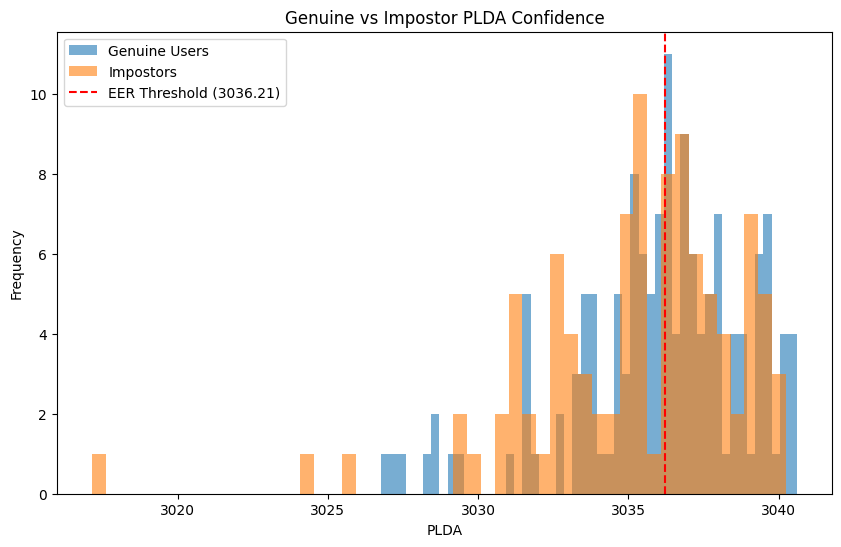

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(genuine_scores, bins=50, alpha=0.6, label="Genuine Users")
plt.hist(impostor_scores, bins=50, alpha=0.6, label="Impostors")
plt.axvline(eer_threshold, color="red", linestyle="--", label=f"EER Threshold ({eer_threshold:.2f})")
plt.xlabel("PLDA")
plt.ylabel("Frequency")
plt.title("Genuine vs Impostor PLDA Confidence")
plt.legend()
plt.show()